# Phase 2 Final Project

* Student name: Caroline Surratt
* Student pace: Self-Paced
* Scheduled project review date/time: Wednesday, August 23rd at 3:00 PM
* Instructor name: Morgan Jones

# Business Understanding

This analysis was conducted for a company that is interested in creating original video content. However, the company lacks insight as to what types of films perform best at the box office. This analysis seeks to understand patterns and trends in movie performance in order to recommend what types of films the company should produce to maximize profit. 

For the purpose of this analysis, movie performance will be evaluated using **percent return on investment**. 



\begin{align}
\text{Percent Return} = \frac{\text{total gross revenue – production budget}}{\text{production budget}}*100
\end{align}


This feature will provide more insight than evaluating **total gross revenue** alone since it takes into consideration the size of the initial investment (in this case, the budget to produce the film).

While other factors (consumer ratings, critic reviews, etc.) may be meaningful in the context of analyzing film as an art form, this company is not necessarily interested in producing Academy-Award-winning films. Rather, they are concerned with earning a profit and maximizing their investments in the new movie studio.

In the analysis that follows, I will examine the relationships between movie performance and movie characteristics (including production budget, genre, and runtime) in order to recommend specific actions the company should take in order to maximize the returns on their investments.

# Data Understanding

Two datasets were used for this analysis.

The first dataset is from The Numbers. This dataset contains information about nearly 6,000 film budgets and revenues from 1915-2020, with most entries falling between the years 2000-2012. This dataset is stored in this repository as a compressed CSV file.

The second dataset is from IMDB. This dataset is a SQLite database with information about over 146,000 movies, including information about each movie's length, when it was released, and its genre. This database also contains information about actors/actresses, directors, and writers, as well as which films they are associated with.

While there are significantly more entries in the IMDB dataset, this information will not be useful to the company without additional information about the profitability of the movie. Therefore, only entries in IMBD that have a corresponding entry in The Numbers dataset will be considered.

# Importing Libraries and Data

First, I will import the libraries and packages necessary for this analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

# turned off chained assignment warning, as I was receiving false positive warnings
pd.options.mode.chained_assignment = None

### The Numbers Dataset

Now, I will import the dataset from The Numbers and preview the DataFrame.

In [3]:
numbers = pd.read_csv("data/tn.movie_budgets.csv.gz")
numbers

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [4]:
numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


This dataset contains information about the budgets and revenues of nearly 6,000 movies, with no missing entries. Before much of the data can be utilized, the numbers must be converted to integers instead of objects. 

For the columns with currency values, I will remove the $ symbol and commas in order to convert these values to a usable type.

For the column with dates, I will adjust the entires so that only contain the year as an integer. Since the IMDB table only contains the release year, this is the only information necessary. Then, the column can be used to match movies to their corresponding entries across the two datasets.

In [5]:
# created a list of the columns that refer to currency values
currency_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']

# used a for loop to remove '$' and ',' symbols from the entries in these columns and convert the remaining
# characters to integers instead of strings
for column in currency_columns:
    numbers[column] = numbers[column].str.replace("$", "")
    numbers[column] = numbers[column].str.replace(",", "")
    numbers[column] = numbers[column].astype(int)

# used a labmda function to select only the year from the release_date column and dropped the column with entire date
numbers['release_year'] = numbers['release_date'].map(lambda x: int(x[-4:]))
numbers.drop('release_date', axis=1, inplace=True)

Now that the columns with numeric values are of a numeric type, we can take a look at the descriptive statistics for this dataset, beginning with the release year.

In [6]:
numbers['release_year'].describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: release_year, dtype: float64

This dataset contains entries about movies that were released as early as 1915. Because the company is interested in films that are currently doing well and film trends have changed significantly in the last century, I will limit this analysis to films that were produced in the 21st century (the year 2000 or later). This will still leave a substantial portion (over 75%) of the dataset for us to work with.

In [7]:
numbers = numbers.loc[numbers['release_year'] >= 2000]

### IMDB Dataset

The Numbers dataset only includes information about the dates, costs, and revenues of movies. In order to consider additional features of these movies (for example, genre and runtime) and evaluate the data for patterns and trends, we will need to incorporate information stored the IMDB file. 

In the cell below, I will connect to the IMDB file using SQLite 3. Then, I will merge the IMDB DataFrame with The Numbers DataFrame. Entries that have insufficient information will not be useful to this analysis; therefore, an inner merge will be used.

In [8]:
# The lines below are commented out to avoid extracting the file multiple times.
    # from zipfile import ZipFile
    # with ZipFile("data/im.db.zip", 'r') as zObject:
        #z Object.extractall(path="data/im.db")

        
# established connection to the database    
conn = sqlite3.connect("data/im.db/im.db")

# created a table called imdb by querying the title, year, runtime, and genres for each movie
imdb = pd.read_sql("""
SELECT original_title, 
       start_year, 
       runtime_minutes,
       genres
FROM movie_basics;""", conn)

# closed the connection to the database
conn.close()

In [9]:
# combined the numbers and imdb tables using an inner merge
# merged on both the title and the year to account for movies with repeated title names

movies = numbers.merge(imdb, how='inner', left_on=['movie', 'release_year'], 
                       right_on=['original_title', 'start_year'])

# Exploratory Analysis

Before analyzing movie performance by any specific feature, I will explore the descriptive statistics of the dataset as a whole.

In [10]:
movies.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year,start_year,runtime_minutes
count,1533.000000,1.533000e+03,1.533000e+03,1.533000e+03,1533.000000,1533.000000,1508.000000
mean,50.504892,4.397901e+07,5.473294e+07,1.371262e+08,2013.893673,2013.893673,106.932361
std,28.749767,5.548813e+07,8.274126e+07,2.275636e+08,2.596904,2.596904,18.836937
min,1.000000,1.500000e+04,0.000000e+00,0.000000e+00,2010.000000,2010.000000,5.000000
25%,25.000000,7.500000e+06,2.483472e+06,7.482387e+06,2012.000000,2012.000000,94.000000
50%,51.000000,2.200000e+07,2.683950e+07,5.044586e+07,2014.000000,2014.000000,105.000000
75%,75.000000,5.500000e+07,6.638066e+07,1.525669e+08,2016.000000,2016.000000,118.000000
max,100.000000,4.106000e+08,7.000596e+08,2.048134e+09,2020.000000,2020.000000,189.000000


The dataset now contains entries for 1,533 movies produced since 2000 for which we have information about the production budget, revenue, release year, runtime, and genre.

The statistics show that on average, each film cost approximately \\$44,000,000 to produce, and on average, each film brought in approximately \\$137,000,000 in worldwide gross revenue.

In order to better understand the relationship between these two variables, I will create a scatterplot below.

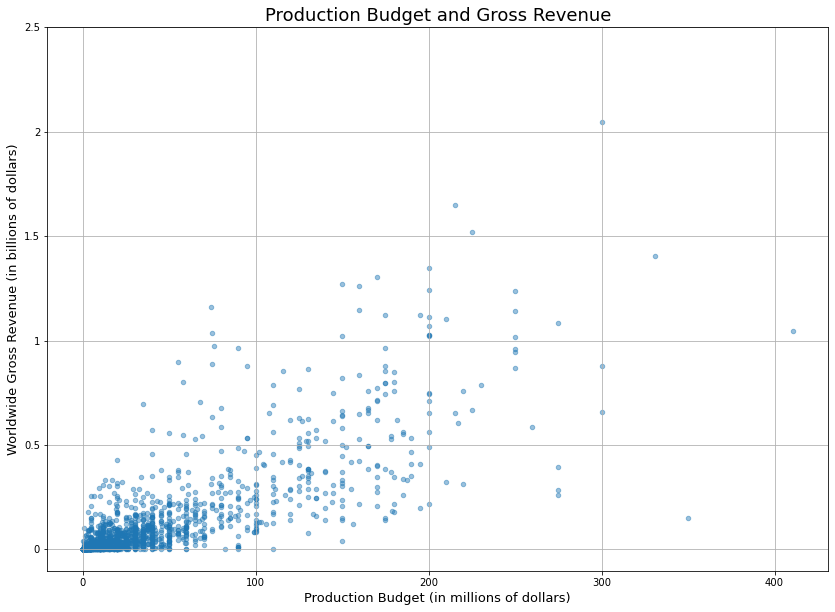

In [11]:
# created a subplot
fig, ax = plt.subplots(figsize=(14,10))

# created a scatterplot for production budget vs. gross revenue
movies.plot.scatter(x="production_budget", y="worldwide_gross", ax=ax, alpha=0.45)
ax.set_title("Production Budget and Gross Revenue", fontsize=18)
ax.set_xlabel("Production Budget (in millions of dollars)", fontsize=13)
ax.set_xticks([0, 100000000, 200000000, 300000000, 400000000])
ax.set_xticklabels([0, 100, 200, 300, 400])
ax.set_ylabel("Worldwide Gross Revenue (in billions of dollars)", fontsize=13)
ax.set_yticks(ticks=[0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000])
ax.set_yticklabels(labels=[0, 0.5, 1, 1.5, 2, 2.5])
ax.grid();

Although this relationship is not linear and does not meet the criteria for performing a linear regression, there does appear to be somewhat of a weak relationship between budget and revenue: films with larger budgets tend to have larger revenues. 

### Percent Return

Looking at total gross revenue will give us some sense of what types of films perform best overall, but it will be more useful to analyze a feature that considers the relationship between revenue and production budget. Therefore, I will create a new column called **"%_return"** that gives the gross revenue as a percentage of the production budget. This feature will provide more insight than evaluating **total gross revenue** alone since it takes into consideration the size of the initial investment (in this case, the budget to produce the film).

The formula used can be seen in the cell below. 

\begin{align}
\text{Percent Return} = \frac{\text{total gross revenue – production budget}}{\text{production budget}}*100
\end{align}

In [12]:
# percent return = (earnings - cost) / cost
movies['%_return'] = (movies['worldwide_gross']-movies['production_budget'])/movies['production_budget']*100

Now, I will  sort the DataFrame by this column so that the most profitable films are easily accessible.

In [13]:
movies.sort_values(by=['%_return'], ascending=False, inplace=True)
movies['%_return'].describe()

count     1533.000000
mean       268.521026
std       1196.362922
min       -100.000000
25%        -28.672900
50%        109.461378
75%        294.571910
max      41556.474000
Name: %_return, dtype: float64

On average, movies in this datset earned a 269% return on their initial investment (that is, approximately 2.5 times what was spent to produce the film). The film with the highest percent return had a whopping 41,556% return on investment! The lowest films had a -100% return (that is, no money was earned from the film, so the entire initial investment was lost).

Again, because **percent return** explains the extent to which the company will be able to profit off of its investments as a proportion (rather than an amount), this feature (rather than total gross revenue) will be the **feature analyzed in order to consider films "highly successful".**

For the remainder of this analysis, "top films", "highly profitable films", and "most successful films" will be used to refer to the **30 films with the highest percent returns**. This sample size will be large enough to draw meaningful conclusions while still only considering films that significantly outperformed the average of the dataset.

# Analysis by Production Budget

## Visual Analysis 

I will begin by creating a scatterplot showing the relationship between production budget and percent return.

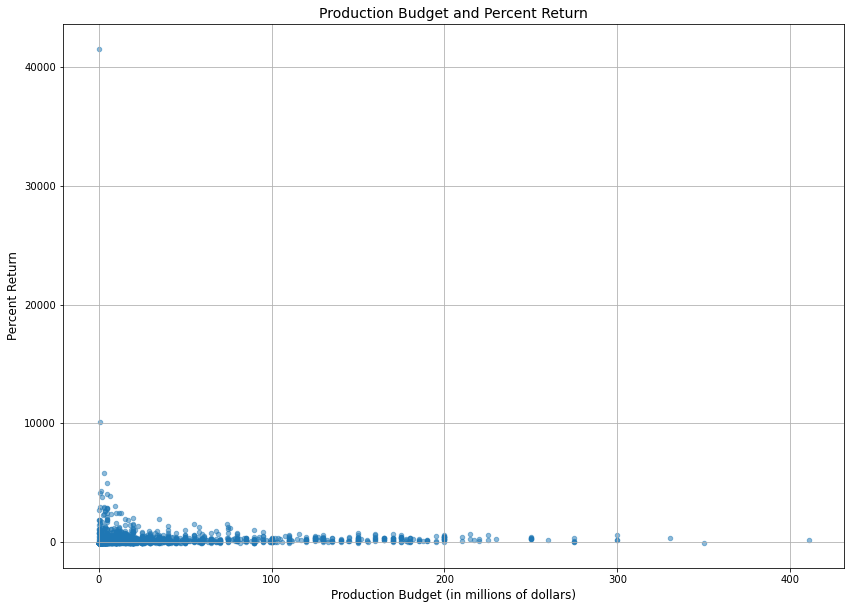

In [14]:
# created a subplot
fig, ax = plt.subplots(figsize=(14,10))

# created a scatterplot for production budget vs. percent return
movies.plot.scatter(x="production_budget", y="%_return", ax=ax, alpha=0.5)
ax.set_title("Production Budget and Percent Return", fontsize=14)
ax.set_xlabel("Production Budget (in millions of dollars)", fontsize=12)
ax.set_xticks([0, 100000000, 200000000, 300000000, 400000000])
ax.set_xticklabels([0, 100, 200, 300, 400])
ax.set_ylabel("Percent Return", fontsize=12)
ax.grid();

Interestingly, the films with the highest percent returns have some of the lowest budgets. These films will be of particular interest to the company, as they demonstrate opportunities to generate impressive returns on investments. However, this visualization is somewhat difficult to interpret, since the two extreme values (the films with returns of approximately 40,000% and 10,000%) significantly affect the y-axis.

In the cell below, I will drop these two extreme values in order to better visualize the relationship for the rest of the data. _**These values will not be dropped from the dataset used for analysis - they are simply being temporariily ignored in order to improve the visualization.**_

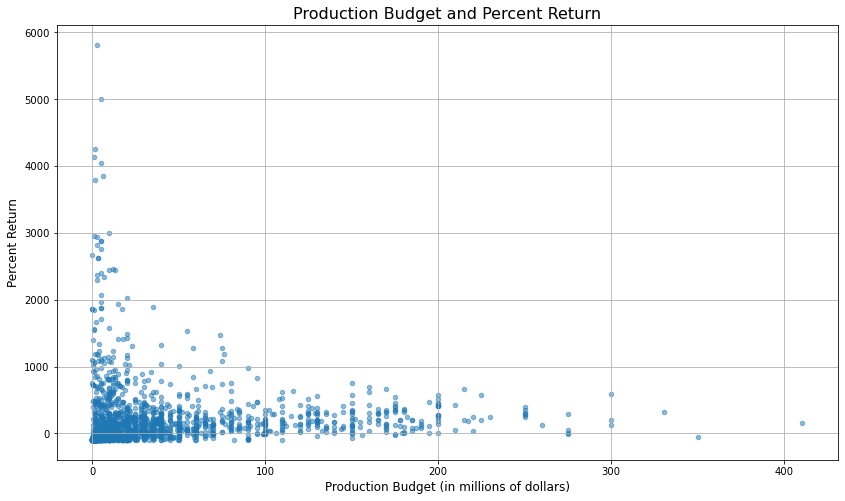

In [15]:
# created a subset of the movies DataFrame that does not contain the extreme values 
movies_without_top_two = movies.loc[movies['%_return'] < 10000]

# created a new scatterplot using the subset
fig, ax = plt.subplots(figsize=(14,8))

movies_without_top_two.plot.scatter(x="production_budget", y="%_return", ax=ax, alpha=0.5)
ax.set_title("Production Budget and Percent Return", fontsize=16)
ax.set_xlabel("Production Budget (in millions of dollars)", fontsize=12)
ax.set_xticks([0, 100000000, 200000000, 300000000, 400000000])
ax.set_xticklabels([0, 100, 200, 300, 400])
ax.set_ylabel("Percent Return", fontsize=12)
ax.grid();

Now, we can more clearly see the relationship between production budget and percent return. This relationship is still clearly nonlinear, but it is more obvious that the films with the highest percent returns have budgets that are less than \\$100 million.

## Statistical Analysis

In order to better understand this relationship, I will first bin the data according to percent return and examine the budget using the function below.

In [16]:
# created a function that takes one input: the number (n) of top films to consider

def calculate_production_budget(n):
    
    #takes the top n films from the original DataFrame
    top_n = movies.head(n)
    
    #calculates the mean production budget of these top films
    production_budget = top_n['production_budget'].mean()
    
    #prints the mean budget (rounded to the nearest dollar) as well as the number of films considered
    print("The production budget for the ", n, " films with the highest percent return is $", 
          int(production_budget), ".")
    
for n in 5, 30, 50, 100, 250, 500:
    calculate_production_budget(n)

The production budget for the  5  films with the highest percent return is $ 2120000 .
The production budget for the  30  films with the highest percent return is $ 5360000 .
The production budget for the  50  films with the highest percent return is $ 8980000 .
The production budget for the  100  films with the highest percent return is $ 14752126 .
The production budget for the  250  films with the highest percent return is $ 32703130 .
The production budget for the  500  films with the highest percent return is $ 51307315 .


Again, there is not a linear relationship between the production budget and the percent return, but average production budgets produced above illustrate the following: The films that earn the most money per dollar (that is, the films that have the highest return on investment) have lower budgets, on average, than other films.

This led me to question: Are the budgets of these highly profitable movies different from the budgets of all other movies?

In [17]:
# defined a subset of the 30 movies with the highest percent returns
subset = movies.head(30)

# examined the descriptive statistics of the subset
subset.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year,start_year,runtime_minutes,%_return
count,30.00000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000
mean,56.10000,5.360000e+06,6.871923e+07,1.538556e+08,2014.266667,2014.266667,100.933333,4514.323223
std,25.09616,4.670199e+06,4.484561e+07,1.058622e+08,2.598850,2.598850,17.896124,7173.433735
min,2.00000,1.000000e+05,1.594798e+06,2.769782e+06,2010.000000,2010.000000,81.000000,1935.899100
25%,46.75000,2.625000e+06,4.112852e+07,7.741338e+07,2012.000000,2012.000000,87.250000,2412.205265
50%,58.50000,5.000000e+06,6.007848e+07,1.166483e+08,2014.500000,2014.500000,97.500000,2790.310037
75%,68.50000,6.125000e+06,9.775738e+07,2.429355e+08,2016.000000,2016.000000,109.750000,3838.329312
max,92.00000,2.000000e+07,1.760407e+08,4.263512e+08,2018.000000,2018.000000,161.000000,41556.474000


On average, these top 30 movies have a production budget of \\$5,360,000, which is much lower than the average budget for all movies (approximately \\$44,000,000). 

Is this difference statistially significant?

In order to examine this question, I will define highly profitable movies to be the 30 movies with the highest percent return on investment, and I will use a t-test with a standard alpha level of 0.05. 

**Null hypothesis**: Highly profitable movies have the same or higher production budgets compared to all movies.

**Alternative hypothesis**: Highly profitable movies have lower production budgets than all movies.

In [18]:
# converted the budget feature of the subset to a NumPy array
sample = subset['production_budget'].to_numpy()

# defined the population mean as the mean production budget of all movies
mu = movies['production_budget'].mean()

# ran a 1 sample t-test to compare this subset (the sample) to the population of all movies
t_stat, p_value = stats.ttest_1samp(a=sample, popmean=mu)

# divided the resulting p_value by 2 since the stats 1-sample t-test assumes a two-sided test
print(p_value/2)

9.129083110818633e-29


Using the t-statistic and p-value calculated above, we can **reject the null hypothesis** at the standard alpha level of 0.05: it is extremely unlikely that highly profitable movies have the same or higher production budgets than all movies. Highly profitable movies have lower production budgets than all movies.

The graph below illustrates the distribution of all films and highly profitable films by budget.

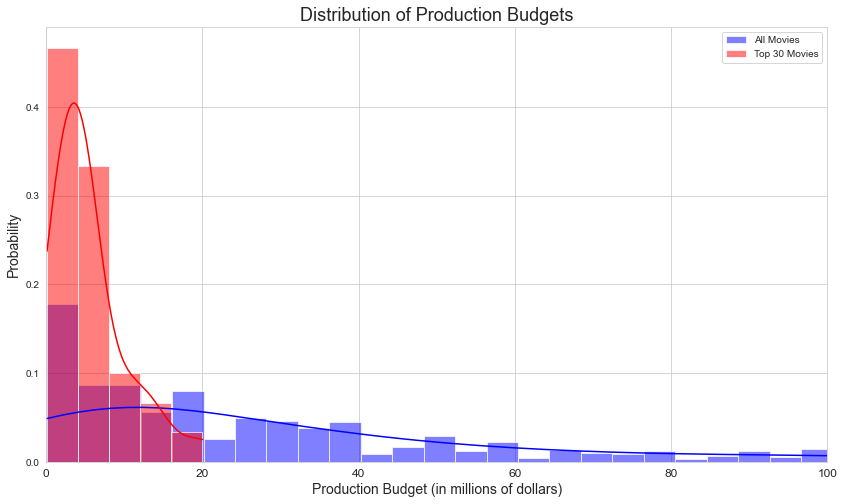

In [19]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14,8))

# created a histogram (with the kde plot) for all movies in blue
sns.histplot(movies['production_budget'], kde=True, bins=102, \
             stat='probability', alpha=0.5, ax=ax, color='blue', label ="All Movies")

# created a histogram (with the kde plot) for the top 30 movies in red
sns.histplot(subset['production_budget'], kde=True, bins=5, \
             stat='probability', alpha=0.5, ax=ax, color='red', label="Top 30 Movies")

# limited x-axis to make visualization more readable
plt.xlim(-10, 100000000)

# adjusted x-axis ticks/labels to avoid scientific notation
plt.xticks(ticks=[0, 20000000, 40000000, 60000000, 80000000, 100000000], 
           labels=[0, 20, 40, 60, 80, 100],
          fontsize=12)

# set titles and labels
plt.title("Distribution of Production Budgets", fontsize=18)
plt.xlabel("Production Budget (in millions of dollars)", fontsize=14)
plt.ylabel("Probability", fontsize=14)

plt.legend();

In blue, we see that all films (denoted in blue) are slightly more concentrated between \\$0-20 million. However, this concentration is not nearly as substantial as the concentration of the 30 most profitable films. These films (denoted in red) are highly concentrated between \\$0-20 million, with the most concentration occurring between \\$0-8 million. No film in the subset has a budget of over \\$20 million. In contrast, the movie with the highest production budget exceeds \\$400 million - over 20 times that of the highest in the subset!

We cannot assume that the production budget *caused* these films to be more profitable. However, this difference in production budget is a statistically significant feature of highly profitable movies.

In order to recommend a specific budget for the company, I will compute a 95\% confidence interval for the mean of the subset. 

We are able to utilize a confidence interval despite the original data not being normally distribute by the central limit theorem.

In [20]:
from scipy.stats import t

mean = subset.production_budget.mean()
std = np.std(subset.production_budget, ddof=1)
error = std/(np.sqrt(30))

stats.t.interval(0.95, 29, mean, error)

(3616119.0366731402, 7103880.96332686)

We can be 95\% confident that the true average production budget for highly successful films falls within the range shown above.

**Therefore, I recommend that the company produce films with budget between \\$3.6 million and \\$7.1 million.** This interval mimics the production budgets of the highly profitable films.

# Analysis by Genre

### Data Preparation

Analysis of movies by genre is not possible using the movies DataFrame in its current state because many of the movies have more than one genre listed in the 'genres' column. Therefore, running the .value_counts() function on this column will be insufficient, as this will return the unique combinations of movie genres and the number they appear as opposed to each unique genre and the number of times it appears. Refer to the cell below for additional context.

In [21]:
# demonstrated why running the .value_counts() function alone is insufficient
movies['genres'].value_counts()

Adventure,Animation,Comedy    68
Drama                         66
Comedy                        54
Comedy,Drama,Romance          52
Action,Adventure,Sci-Fi       49
                              ..
Adventure,Drama,History        1
Action,Sci-Fi                  1
Comedy,Fantasy,Musical         1
Action,Comedy,Sport            1
Comedy,Horror,Sci-Fi           1
Name: genres, Length: 233, dtype: int64

Although it may be possible to gain some information from these values, it will be more meaningful to extract the counts for individual genre. This will allow for a more specific recommendation to the company.

By adapting a flatten_list() functon from user Alex Martelli on Stack Overflow, I will split the value counts above, flatten the list, and return only the unique genres.

In [22]:
def split_and_flatten(list):
    
    # initialized an empty list
    split_list = []
    
    # splits the .value_counts() indices at each comma
    for entry in list:
        split_list.append(entry.split(','))
    
    # returns the set of the flattened list of indices (provided by Alex Martelli)
    # citation: https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    return set([item for sublist in split_list for item in sublist])

genres = split_and_flatten(list(movies['genres'].value_counts().index))
genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

Now, we have a list of each genre that appears in the genres column. 

In order to determine how often each genre appears in the dataset, I will create a function that counts the number of entries for each genre and returns a DataFrame with the genres and their counts.

In [23]:
# imported necessary library and established helper function
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# created a new function that takes one argument: the list of genres
def number_in_genre(genres_list):
    
    # initializes and empty list
    dataframes = []
    
    # loop runs a query on each genre word in the genre list and returns the number of entries that
    # contain the genre word in the genres column
    for genre in genres_list:
        q = """SELECT COUNT(*) 
               FROM movies 
               WHERE genres LIKE '%""" + genre + """%'"""
        
        # returns the result (a series with the count from the query) as the variable df
        df = pysqldf(q)
       
        # creates a new column called "genres" whose value is the name of the genre counted
        df['genre'] = genre
        
        # append df to the dataframes list
        dataframes.append(df)
        
    # concatenates all of the dataframes in the dataframes list into one dataframe with each genre/count combination   
    return pd.concat(dataframes)

Now, I will run the above function using the list of genres. This will return a DataFrame with each genre and the number of times that genre appears in the dataset.

In [24]:
all_movie_genres = number_in_genre(genres)

#extracted to numpy array for chi2 test
all_movie_genres_array = all_movie_genres['COUNT(*)'].to_numpy()

#sorted the DataFrame by counts
all_movie_genres.sort_values(by=["COUNT(*)"], inplace=True)
all_movie_genres

,COUNT(*),genre
0,1,Reality-TV
0,9,Musical
0,10,Western
0,17,War
0,34,Sport
0,40,History
0,51,Documentary
0,59,Music
0,96,Family
0,104,Animation


For the entire dataset, the most common genres are drama, comedy, and action. These results can be seen visually in the bar graph below.

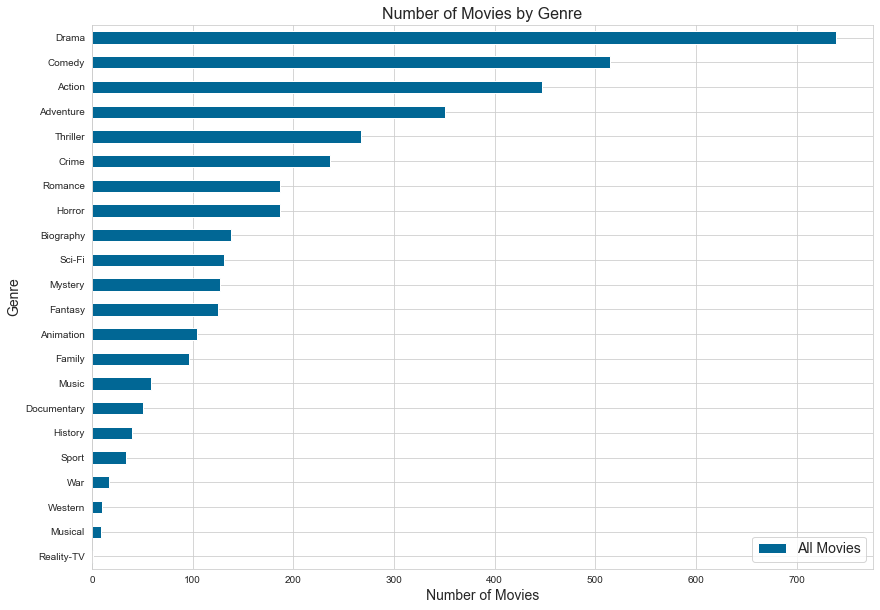

In [25]:
fig, ax = plt.subplots(figsize=(14,10))

all_movie_genres.plot.barh(x='genre', y='COUNT(*)', label='All Movies', ax=ax,
                          color='#016795')
plt.title('Number of Movies by Genre', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.legend(loc=4, fontsize=14);

Now, I will examine the breakdown by genre for only the most profitable movies.

I will once again use a function that counts the number of entries for each genre and returns a DataFrame with the genres and their counts. However, I will adjust the function so that it queries the subset DataFrame (which only contains the 30 movies with the highest percent returns) instead of the movies DataFrame (which contains all movies).

In [26]:
# Note that the function below is identical to the function above except for the "FROM" line of the query,
# which has been changed to "subset" instead of "movies"

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        # The below que
        q = """SELECT COUNT(*)
               FROM subset 
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

top_movie_genres = number_in_genre(genres)
top_movie_genres_array = top_movie_genres['COUNT(*)'].to_numpy()
top_movie_genres

top_movie_genres.sort_values(by=["COUNT(*)"], inplace=True)
top_movie_genres

,COUNT(*),genre
0,0,Musical
0,0,Family
0,0,Sci-Fi
0,0,Sport
0,0,Reality-TV
0,0,Western
0,0,Adventure
0,0,War
0,0,History
0,0,Crime


For the most profitable movies, the most common genres are horror, thriller, and drama. These results can be seen visually in the bar graph below.

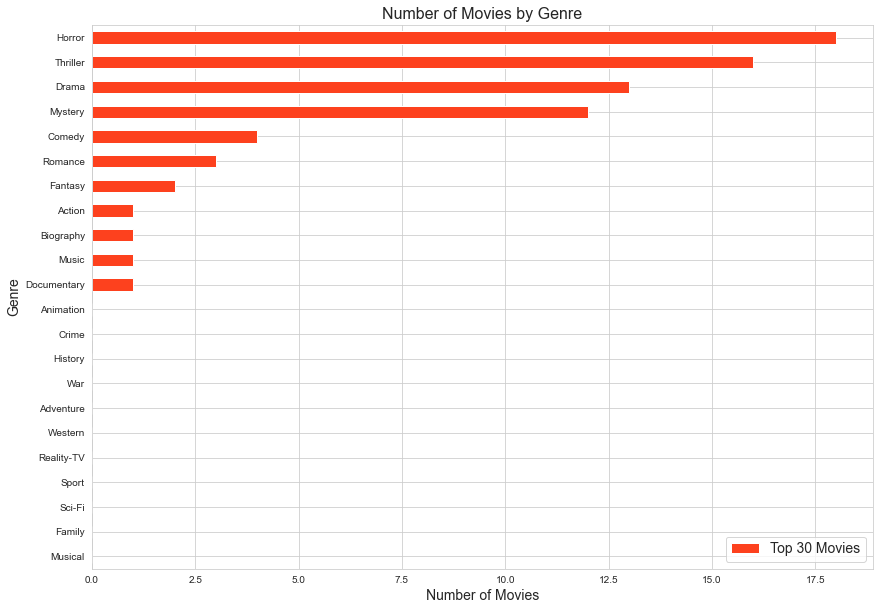

In [27]:
fig, ax = plt.subplots(figsize=(14,10))

top_movie_genres.plot.barh(x='genre', y='COUNT(*)', label='Top 30 Movies', ax=ax,
                          color='#fd411e')
plt.title('Number of Movies by Genre', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.legend(loc=4, fontsize=14);

Fewer genres are represented in the top 30 movies subset, and there is a larger proporiton of movies in the most common genre categories.

## Visual Analysis

In order to compare the subset to all movies, I will adjust the columns of each DataFrame so that they use percentages rather than raw counts. Then, I will merge the DataFrames and create a double bar graph to compare the results visually.

In [28]:
# divided each count by the number of movies in the DataFrame
all_movie_genres['Percent of'] = all_movie_genres['COUNT(*)'].map(lambda x: x/(len(movies))*100)
top_movie_genres['Percent of'] = top_movie_genres['COUNT(*)'].map(lambda x: x/(len(subset))*100)

# dropped the count column
for table in [all_movie_genres, top_movie_genres]:
    table.drop('COUNT(*)', axis=1, inplace=True)
    
# renamed the columns so they are specific to the data they represent
all_movie_genres.rename(columns={'Percent of':'Percent of All Movies'}, inplace=True)
top_movie_genres.rename(columns={'Percent of':'Percent of Top 30 Movies'}, inplace=True)

# merged the DataFrames and sorted the values
genre_comparison = all_movie_genres.merge(top_movie_genres, on='genre')
genre_comparison.sort_values(by=['Percent of Top 30 Movies'], ascending=True, inplace=True)

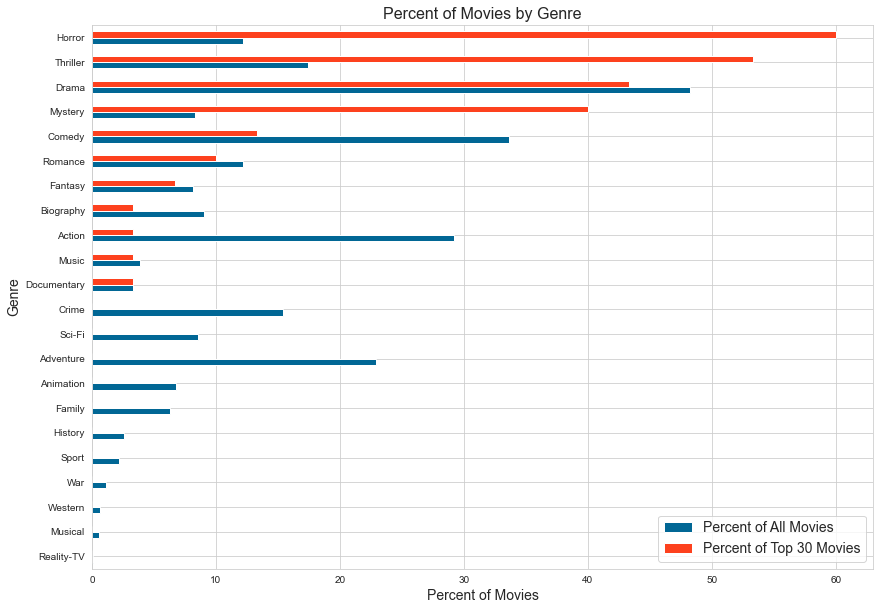

In [29]:
fig, ax = plt.subplots(figsize=(14,10))

genre_comparison.plot(x='genre', y=['Percent of All Movies', 'Percent of Top 30 Movies'],
                     kind="barh", ax=ax, color=['#016795', '#fd411e'])
plt.title("Percent of Movies by Genre", fontsize=16)
plt.xlabel("Percent of Movies", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.legend(loc=4, fontsize=14);

This graph clearly shows that there are some key differences in the subset of highly profitable movies compared to the dataset with all movies. However, it is somewhat difficult to interpret all of the information at once, and some of this information (i.e. the genres for which there are no highly profitable movies) will not be useful in my recommendations.

Because the company is interested in maximizing profit, I will create a second visualization that only includes the most common genres for the top 30 movies. This will improve readability of the graph and better illuminate the relationship between genre and percent return.

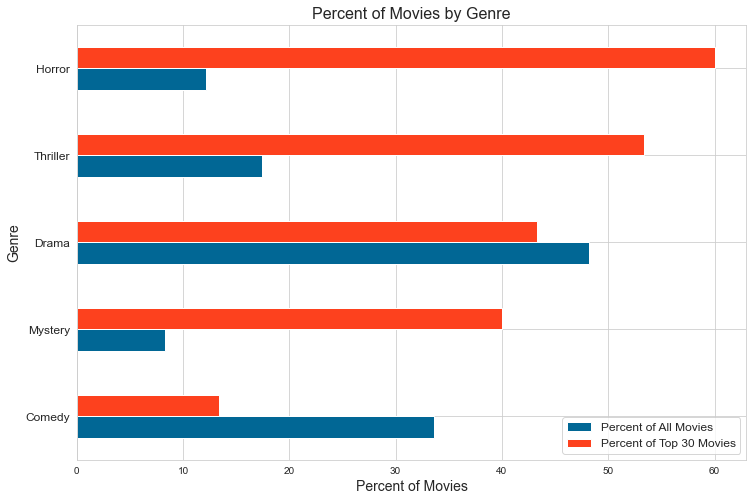

In [30]:
fig, ax = plt.subplots(figsize=(12,8))

genre_comparison.tail(5).plot(x='genre', y=['Percent of All Movies', 'Percent of Top 30 Movies'],
                     kind="barh", ax=ax, color=['#016795', '#fd411e'])
plt.title("Percent of Movies by Genre", fontsize=16)
plt.xlabel("Percent of Movies", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc=4, fontsize=12);

The majority of movies in the highly profitable subset are classified as "Horror" (60%)  and/or "Thriller" (53%). However, a much smaller portion of all movies (12% and 17%, respectively) fit this classification. 

Similarly, the proportion of movies classified as "Mystery" is much larger for the highly profitable movies (40%) than for all movies (8%). 

By contrast, about 34% of all movies are classified as "Comedy", while only approimately 13% of highly profitable movies fall into this category.

The proportion for "Drama" is similar the categories: approximately 48% for all movies and 43% for the subset.

## Statistical Analysis

Could the differences in these breakdowns be attributed to chance, or are these subsets actually behaving differently? In order to test whether these differences are statistically significant, I will perform a chi-squared contingency test with the standard alpha value of 0.05.

**Null hypothesis**: There is no difference in genre breakdown for highly profitable movies compared to all movies.

**Alternative hypothesis**: There is a difference in genre breakdown for highly profitable movies compared to all movies.

In [31]:
# Note that the array variables were extracted earlier in the analysis (before the values were sorted by count 
# and before the counts were transformed into percentages)

contingency_table = np.array([all_movie_genres_array,
                             top_movie_genres_array])

stats.chi2_contingency(contingency_table)

(144.25734033778772,
 2.1524141199666226e-20,
 21,
 array([[5.09522952e+02, 2.01256657e+02, 2.31690591e+02, 1.24680954e+02,
         5.89043875e+01, 3.92695917e+01, 5.10504692e+01, 1.02100938e+02,
         1.86530560e+02, 3.44590667e+02, 8.83565813e+00, 9.81739792e+00,
         9.81739792e-01, 3.33791529e+01, 1.28607913e+02, 9.42470200e+01,
         1.36461831e+02, 4.39819427e+02, 2.77832361e+02, 7.38268324e+02,
         1.36461831e+02, 1.66895765e+01],
        [9.47704793e+00, 3.74334263e+00, 4.30940908e+00, 2.31904641e+00,
         1.09561248e+00, 7.30408319e-01, 9.49530814e-01, 1.89906163e+00,
         3.46943951e+00, 6.40933300e+00, 1.64341872e-01, 1.82602080e-01,
         1.82602080e-02, 6.20847071e-01, 2.39208724e+00, 1.75297996e+00,
         2.53816891e+00, 8.18057317e+00, 5.16763885e+00, 1.37316764e+01,
         2.53816891e+00, 3.10423535e-01]]))

The extremely low p-value allows us to **reject the null hypothesis** at the standard alpha level of 0.05: it is extremely unlikely that these two groups behave the same way with regard to distribution across genre. 

**Therefore, I recommend taht the company mimic the genre distribution of the highly profitable films and produce films classified as "Horror", "Thriller", "Drama", and/or "Mystery".** Films in these genre categories make up the vast majority of highly profitable films.

# Analysis by Runtime

## Visual Analysis

Next, I will explore the relationship between runtime and percent return. First, I will visualize the relationship with a scatterplot.

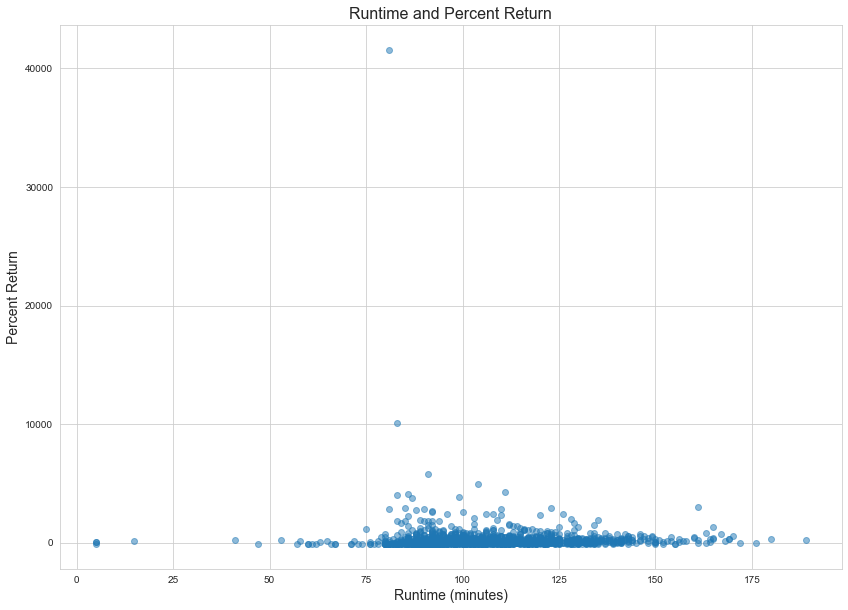

In [32]:
fig, ax = plt.subplots(figsize=(14,10))

plt.scatter(x=movies['runtime_minutes'], y=movies['%_return'], alpha=0.5)
plt.title("Runtime and Percent Return", fontsize=16)
plt.xlabel("Runtime (minutes)", fontsize=14)
plt.ylabel("Percent Return", fontsize=14);

There does not appear to be a clear relationship between movie runtime and percent return. However, it is clear that the two movies with the highest percent returns have similar runtimes - approximately 80-85 minutes. These two movies are so far above the others that they make the graph somewhat difficult to interpret, as they compress the y-axis significantly. In order to better visualize this relationship, I will drop the two most profitable movies and examine the remaining data points.

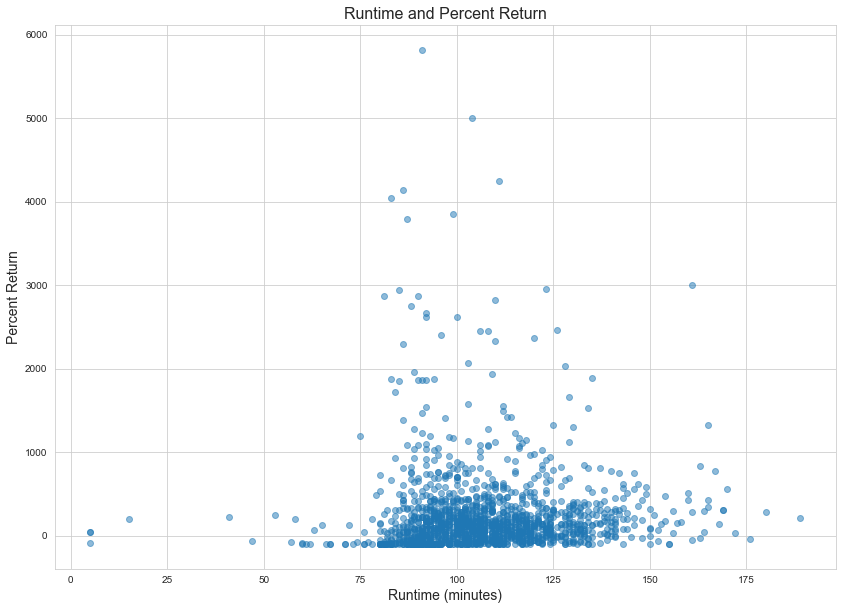

In [33]:
movies_without_top_two = movies.loc[movies['%_return']<10000]

fig, ax = plt.subplots(figsize=(14,10))

plt.scatter(x=movies_without_top_two['runtime_minutes'], y=movies_without_top_two['%_return'], alpha=0.5)
plt.title("Runtime and Percent Return", fontsize=16)
plt.xlabel("Runtime (minutes)", fontsize=14)
plt.ylabel("Percent Return", fontsize=14);

Again, although there is not a linear relationship between these two variables, it does appear that many of the most profitable movies are clustered between approximately 80-130 minutes.

## Statistical Analysis

In order to better understand the relationship between these two variables, I will bin the data according to percent return and analyze the runtime using the function below.

In [34]:
# created a function that takes one input: the number (n) of top films to consider

def calculate_runtime(n):
    
    #takes the top n films from the original DataFrame
    top_n = movies.head(n)
    
    #calculates the mean runtime of these top films
    runtime = top_n['runtime_minutes'].mean()
    
    #prints the mean runtime (rounded to the nearest minute) as well as the number of films considered
    print("The runtime for the ", n, " films with the highest percent return is", 
          int(runtime), "minutes.")
    
for n in 5, 30, 50, 100, 250, 500:
    calculate_runtime(n)

The runtime for the  5  films with the highest percent return is 94 minutes.
The runtime for the  30  films with the highest percent return is 100 minutes.
The runtime for the  50  films with the highest percent return is 102 minutes.
The runtime for the  100  films with the highest percent return is 104 minutes.
The runtime for the  250  films with the highest percent return is 108 minutes.
The runtime for the  500  films with the highest percent return is 109 minutes.


In [35]:
print("The average runtime for the most profitable films is {} minutes, with a standard deviation \
of {}.".format(round(subset.runtime_minutes.mean()), 
               round(np.std(subset.runtime_minutes, ddof=1))))
print("The average runtime for all films is {} minutes, with a standard deviation \
of {}.".format(round(movies.runtime_minutes.mean()), 
               round(np.std(movies.runtime_minutes))))

The average runtime for the most profitable films is 101.0 minutes, with a standard deviation of 18.0.
The average runtime for all films is 107.0 minutes, with a standard deviation of 19.0.


Interestingly, the movies with the highest percent returns have shorter runtimes, on average, than other films. Is this difference statistically significant? In order to test this, I will conduct a t-test.

**Null hypothesis**: Highly profitable movies have the same or longer runtimes compared to all movies.

**Alternative hypothesis**: Highly profitable movies have shorter runtimes than all movies.

In [36]:
# converted the runtime feature of the subset to a NumPy array
sample = subset['runtime_minutes'].to_numpy()

# defined the population mean as the mean runtime of all movies
mu = movies['runtime_minutes'].mean()

# ran a 1 sample t-test to compare this subset (the sample) to the population of all movies
t_stat, p_value = stats.ttest_1samp(a=sample, popmean=mu)

# divided the resulting p_value by 2 since the stats 1-sample t-test assumes a two-sided test
print(p_value/2)

0.03831205165706183


Using the p-value calculated above, we can reject the null hypothesis at the standard alpha level of 0.05: it is  unlikely that highly profitable movies have the same or higher runtimes compared to all movies. Highly profitable movies appear to have lower runtimes than all movies, on average.

We cannot assume that the runtime _caused_ these films to be more profitable. However, this difference is a statistically significant feautre of highly profitable movies.

In order to recommend a specific runtime for the company's movies, I will compute a 95% confidence interval for the mean of the subset. We are able to utilize a confidence interval by the central limit theorem despite the runtimes of this subset not being normally distributed.

In [37]:
mean = subset.runtime_minutes.mean()
std = np.std(subset.runtime_minutes, ddof=1)
error = std/np.sqrt(30)

stats.t.interval(0.99, 29, mean, error)

(91.92719983942452, 109.93946682724216)

We can be 99% confident that the true average length for highly profitable films falls within the range shown above.

**Therefore, I recommend that the company produce films between 92 and 110 minutes in length.**

# Conclusion

While there are many ways to determine what makes a movie "successful" (critical acclaim, number of viewers, public opinion, etc.), the company's primary measure of succss will be profitability. Therefore, in conducting this analysis, I utilized percent return. I used this feature in order to define a subset of the most successful movies. Then, I analyzed this subset to determine how the movies in the subset behave compared to all movies we have data for.

This analysis led me to three key findings:

* **On average, highly successful movies have lower production budgets than all movies.**  I recommend that the company produce films with budget between \\$3.6 million and \\$7.1 million. We can be 95% confident that the true average production budget for highly successful films falls within this range, despite it being significantly smaller than the average production budget for all films (approximately \\$44 million).


* **The majority of highly successful movies are classified as Horror, Thriller, Drama, and/or Mystery movies.** The difference in breakdown of movies by genre for the subset compared to all movies is statistically significant: that is, it is unlikely that there are more movies in these categories due to random chance. Therefore, I recommend that the company focus their production efforts on movies in these categories.


* **On average, highly successful movies are slightly shorter than all movies.** While this difference is slight (101 minutes compared to 107 minutes), it is statistically significant at the standard alpha level of 0.05. Therefore, I recommend that the company produce films with runtimes between 92 and 110 minutes in length. We can be 95\% confident that the true average runtime for highly successful films falls within this range.